# PRE - PROCESSING

## Import functions

In [18]:
!pip install meteostat

In [19]:
pip install keras-tuner --upgrade

In [20]:
import holidays # For working with holiday data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb

from datetime import datetime
from meteostat import Stations, Daily # For working with weather data
from xgboost import plot_importance


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

In [21]:
## Features Functions

def create_datetime_features(df):

    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['date'] = pd.to_datetime(df.index.date)
    return df

def get_holiday_features(df, country_code='US'):
    """
    Creates holiday features from datetime index
    """
    year_range = list(range(min(df.index.year), max(df.index.year) + 1))
    country_holidays = holidays.country_holidays(
        country_code,
        years=year_range,
        observed=False
    )
    holiday_df = pd.DataFrame(country_holidays.items())
    holiday_df.columns = ['date', 'holiday']
    holiday_df['date'] = pd.to_datetime(holiday_df['date'])
    return holiday_df

def get_weather_features(df, lat, lon):
    """
    Creates weather features based on latitude and longitude
    """
    room_temperature = 20  # Weather data is in Celsius
    start = min(df.index)
    end = max(df.index)

    stations = Stations()
    stations = stations.nearby(lat, lon)
    station = stations.fetch(1)

    # Get daily data
    weather_data = Daily(station['wmo'][0], start, end)
    weather_data = weather_data.fetch()
    weather_data = weather_data.dropna(axis=1)
    weather_data = weather_data.reset_index()
    weather_data['tmin_abs_diff_from_room_temperature'] = abs(weather_data['tmin'] - room_temperature)
    weather_data['tmax_abs_diff_from_room_temperature'] = abs(weather_data['tmax'] - room_temperature)
    weather_data = weather_data.rename(columns ={'time': 'date'})

    return weather_data

## Import data and feature engineering

In [22]:
main = 'https://raw.githubusercontent.com/Brunchcode/Forecasting-Energy-Consumption-Using-Machine-Learning/main/data/Timeseries/Timeseries_PJM_DOM_consumption_2006_to_2024.csv'

data_main = pd.read_csv(main,index_col=[0], parse_dates=[0])
data = create_datetime_features(data_main)
holiday_features = get_holiday_features(data)
weather_features = get_weather_features(data, 37.5407, -77.4360) # Richmond Capital of Virgina
data['datetime'] = data.index
data = data.merge(holiday_features, how='left', on='date')
data['holiday'] = data['holiday'].fillna('')
data = pd.get_dummies(data)
data = data.merge(weather_features, how='left', on='date')


remove_for_case_study = datetime(2020, 1, 1)
data_till_2019 = data.loc[data['datetime'] <= remove_for_case_study].copy()
case_study_data = data.loc[data['datetime'] > remove_for_case_study].copy()

In [23]:
case_study_data.head()

,energy_consumption_mw,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,...,holiday_Thanksgiving,holiday_Veterans Day,holiday_Washington's Birthday,tavg,tmin,tmax,prcp,wspd,tmin_abs_diff_from_room_temperature,tmax_abs_diff_from_room_temperature
122713,10291.858,2020-01-01,1,2,1,1,2020,1,1,1,...,False,False,False,7.1,1.7,12.2,0.0,13.7,18.3,7.8
122714,10252.082,2020-01-01,2,2,1,1,2020,1,1,1,...,False,False,False,7.1,1.7,12.2,0.0,13.7,18.3,7.8
122715,10303.804,2020-01-01,3,2,1,1,2020,1,1,1,...,False,False,False,7.1,1.7,12.2,0.0,13.7,18.3,7.8
122716,10588.920,2020-01-01,4,2,1,1,2020,1,1,1,...,False,False,False,7.1,1.7,12.2,0.0,13.7,18.3,7.8
122717,10980.540,2020-01-01,5,2,1,1,2020,1,1,1,...,False,False,False,7.1,1.7,12.2,0.0,13.7,18.3,7.8


In [24]:
case_study_data.tail()

,energy_consumption_mw,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,...,holiday_Thanksgiving,holiday_Veterans Day,holiday_Washington's Birthday,tavg,tmin,tmax,prcp,wspd,tmin_abs_diff_from_room_temperature,tmax_abs_diff_from_room_temperature
162882,20498.376,2024-07-31,19,2,3,7,2024,213,31,31,...,False,False,False,26.2,22.2,32.2,0.3,7.9,2.2,12.2
162883,19814.648,2024-07-31,20,2,3,7,2024,213,31,31,...,False,False,False,26.2,22.2,32.2,0.3,7.9,2.2,12.2
162884,18910.259,2024-07-31,21,2,3,7,2024,213,31,31,...,False,False,False,26.2,22.2,32.2,0.3,7.9,2.2,12.2
162885,17645.255,2024-07-31,22,2,3,7,2024,213,31,31,...,False,False,False,26.2,22.2,32.2,0.3,7.9,2.2,12.2
162886,16421.592,2024-07-31,23,2,3,7,2024,213,31,31,...,False,False,False,26.2,22.2,32.2,0.3,7.9,2.2,12.2


# CASE STUDY

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - loss: 0.0040 - val_loss: 0.0030
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms

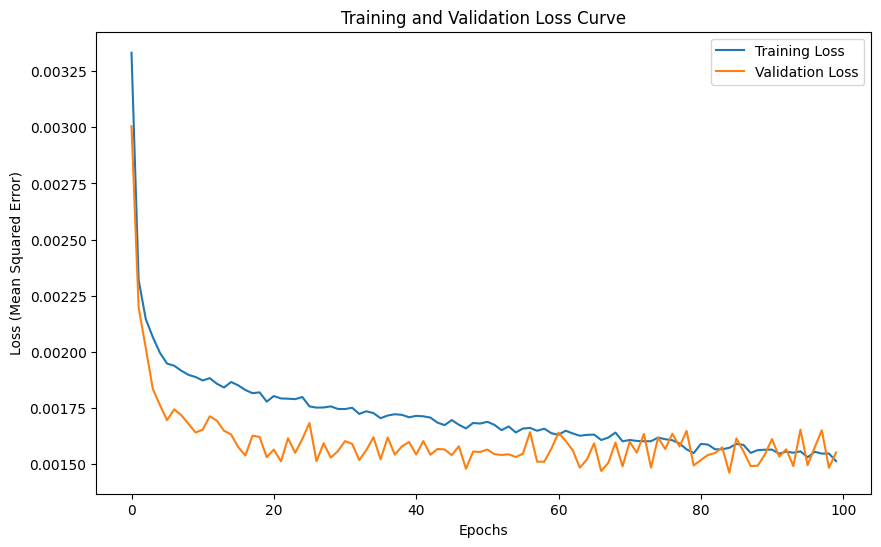

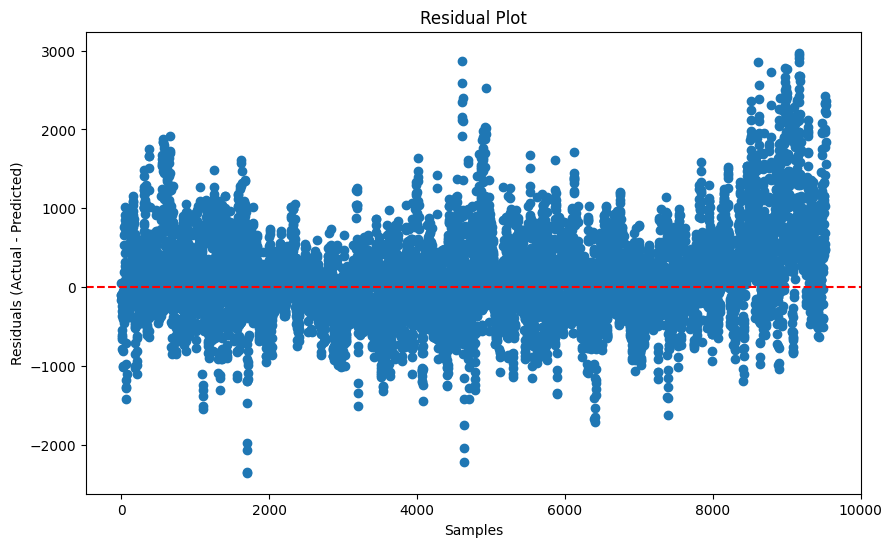

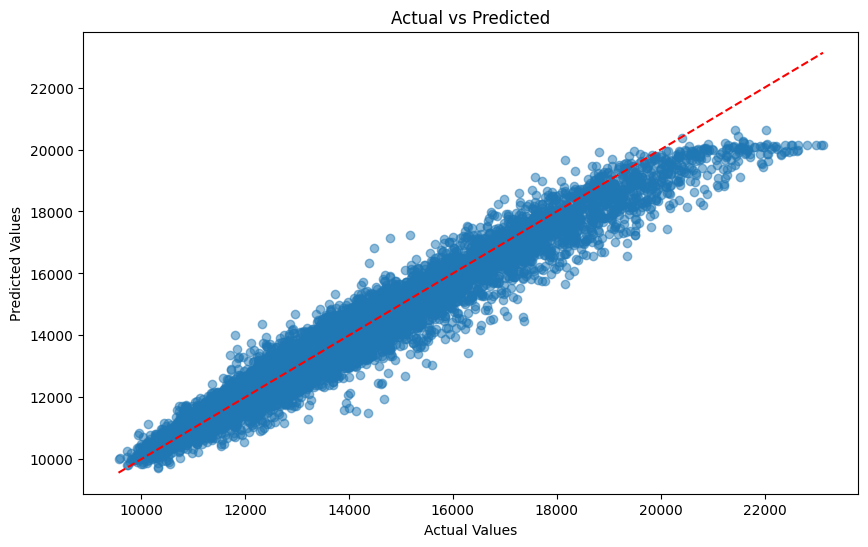

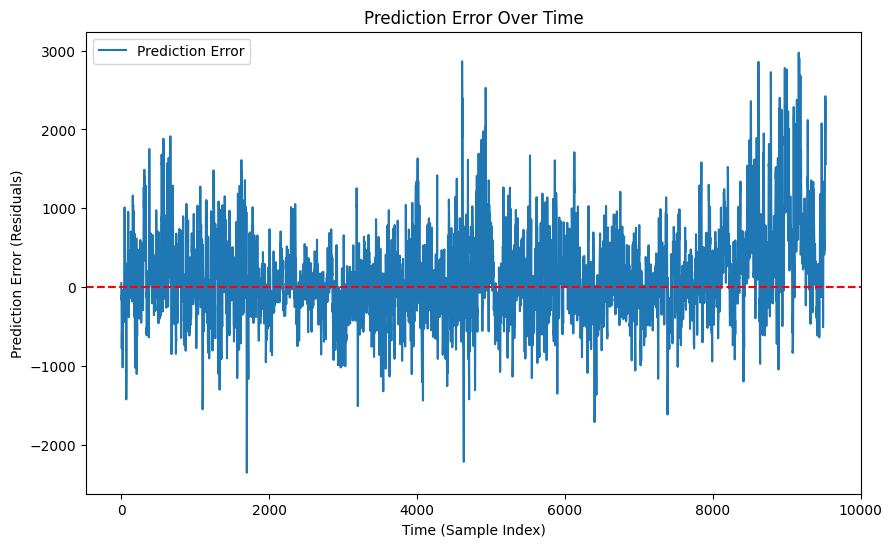

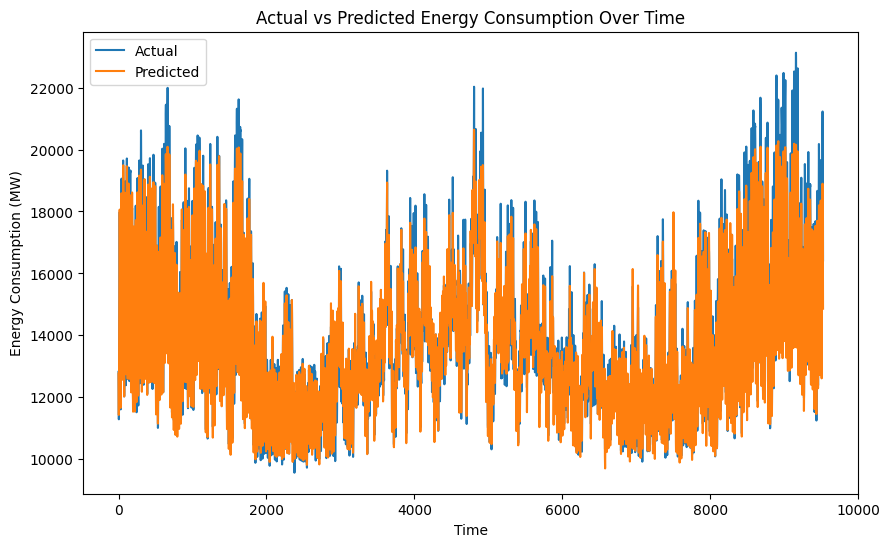

In [25]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from datetime import datetime
import tensorflow as tf
import random

# Step 0: Set seeds for reproducibility
def set_seeds(seed=22):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    # For GPU reproducibility (if applicable) - TensorFlow 2.x way
    # No need for explicit session management in TF 2.x

set_seeds()

# Step 1: Prepare the case study data (2020-2023 training, 2024 testing)
split_date_train = datetime(2023, 7, 1)
train = case_study_data.loc[case_study_data['datetime'] < split_date_train].copy()
test = case_study_data.loc[case_study_data['datetime'] >= split_date_train].copy()

train_drop_cols = ['date', 'datetime', 'energy_consumption_mw']
X_train = train.drop(columns=train_drop_cols)
y_train = train['energy_consumption_mw']
X_test = test.drop(columns=train_drop_cols)
y_test = test['energy_consumption_mw']

# Step 2: Normalize the data using MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Reshape input to be [samples, time steps, features] for LSTM
X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Step 3: Load the best pre-trained model
loaded_model = load_model('lstm_energy_model1.h5')

# Step 3.1: Recompile the loaded model with a fresh optimizer
loaded_model.compile(optimizer=Adam(), loss='mean_squared_error')

# Step 4: Retrain the loaded model on 2020-2023 data
history = loaded_model.fit(X_train_scaled, y_train_scaled,
                           validation_data=(X_test_scaled, y_test_scaled),
                           epochs=100,
                           batch_size=1000,
                           verbose=1)

# Step 5: Make predictions on 2024 data
predictions = loaded_model.predict(X_test_scaled)

# Step 6: Define the evaluation and plotting function
def evaluate_and_plot_model(y_true, y_pred, history=None):
    y_true_inv = scaler_y.inverse_transform(y_true)
    y_pred_inv = scaler_y.inverse_transform(y_pred)

    # Calculate evaluation metrics
    rmse = mean_squared_error(y_true_inv, y_pred_inv, squared=False)
    mae = mean_absolute_error(y_true_inv, y_pred_inv)
    mape = mean_absolute_percentage_error(y_true_inv, y_pred_inv)
    r2=r2_score(y_true_inv, y_pred_inv)



    print('---------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------')

    # Print evaluation metrics
    print("Evaluation Metrics:")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"MAPE: {mape}")
    print(f"R2: {r2}")


    print('---------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------')

    print('plots:')

    # 6.1 Loss Curve
    if history is not None:
        plt.figure(figsize=(10,6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Loss (Mean Squared Error)')
        plt.legend()
        plt.show()

    # 6.2 Residual Plot
    residuals = y_true_inv - y_pred_inv
    plt.figure(figsize=(10,6))
    plt.scatter(range(len(residuals)), residuals)
    plt.axhline(0, color='r', linestyle='--')
    plt.title('Residual Plot')
    plt.xlabel('Samples')
    plt.ylabel('Residuals (Actual - Predicted)')
    plt.show()

    # 6.3 Actual vs Predicted Scatter Plot
    plt.figure(figsize=(10,6))
    plt.scatter(y_true_inv, y_pred_inv, alpha=0.5)
    plt.plot([y_true_inv.min(), y_true_inv.max()], [y_true_inv.min(), y_true_inv.max()], 'r--')
    plt.title('Actual vs Predicted')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.show()

    # 6.4 Prediction Error Over Time
    plt.figure(figsize=(10,6))
    plt.plot(residuals, label='Prediction Error')
    plt.title('Prediction Error Over Time')
    plt.xlabel('Time (Sample Index)')
    plt.ylabel('Prediction Error (Residuals)')
    plt.axhline(0, color='r', linestyle='--')
    plt.legend()
    plt.show()

    # 6.5 Actual vs Predicted Over Time
    plt.figure(figsize=(10,6))
    plt.plot(y_true_inv, label='Actual')
    plt.plot(y_pred_inv, label='Predicted')
    plt.title('Actual vs Predicted Energy Consumption Over Time')
    plt.xlabel('Time')
    plt.ylabel('Energy Consumption (MW)')
    plt.legend()
    plt.show()

# Step 7: Evaluate the retrained model and plot results
evaluate_and_plot_model(y_test_scaled, predictions, history)


In [26]:
# Save the model after training
loaded_model.save('lstm_case_study_energy_model1.h5')

In [27]:
loaded_model.save('lstm_case_study_energy_model1.keras')